# Imports and auxiliary functions

In [100]:
from cpflow import *
from cpflow.topology import *
from cpflow.trigonometric_utils import random_angles, bracket_angle
from cpflow.matrix_utils import theoretical_lower_bound, cost_HST
from cpflow.main import RegularizationOptions
from cpflow.penalty import make_regularization_function
from cpflow.gates import u_toff3, u_toff4, u_toff5
from cpflow.trigonometric_utils import bracket_angle
from cpflow.exact_decompositions import remove_zero_rgates

from jax import vmap
from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import *
from qiskit.quantum_info import OneQubitEulerDecomposer, random_clifford, Operator
from qiskit.extensions import UnitaryGate

from scipy.stats import unitary_group
from fractions import Fraction
from pandas import DataFrame

import pickle
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

def get_placements(circuit):
    placemets = []
    for gate, qargs, cargs in circuit.data:
        if gate.name == 'cz':
            i0 = qargs[0]._index
            i1 = qargs[1]._index
            placemets.append([i0, i1])
    return placemets

def mean_and_std(results):
    mean_list = []
    std_list = []
    for i in range(len(results[0])):
        sr_list = jnp.array([res[i]['success_ratio'] for res in results])
        mean_list.append(jnp.mean(sr_list))
        std_list.append(jnp.std(sr_list))
    
    return mean_list, std_list        

def refactor_results(path):
    import dill
    sys.path.append('/home/idnm/Programming projects/jax_circuits/cpflow/')
    
    sys.modules['jax_circuits'] = cpflow.main
    sys.modules['penalty'] = cpflow.penalty
    sys.modules['cp_utils'] = cpflow.cp_utils
    
    with open(path, 'rb') as f:
        results = dill.load(f, ignore=True)
        
    results.save()

# Variational synthesis and its challanges

## Empirical success ratio: definition and example

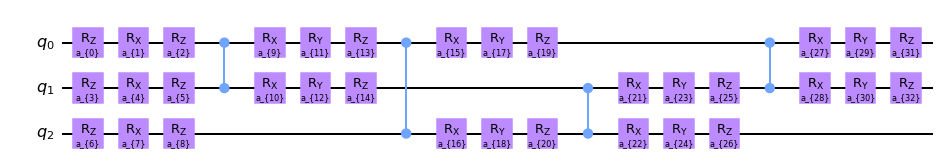

In [2]:
anz = Ansatz(3, 'cz', fill_layers(connected_layer(3), 4))
target_angles = random_angles(anz.num_angles)
target_circuit = anz.circuit(target_angles)
target_unitary = anz.unitary(target_angles)

anz.circuit().draw(output='mpl')

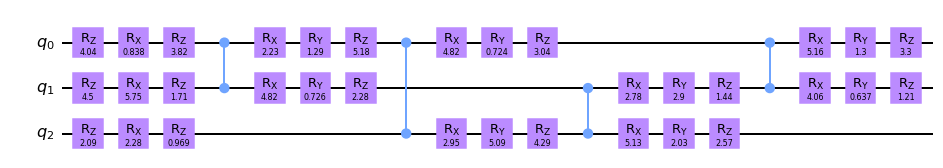

In [3]:
target_circuit.draw(output='mpl')

Success ratio of our default optimization procedure:

In [4]:
results = anz.learn(
    target_unitary, 
    method='adam',
    learning_rate=0.1,
    num_iterations=5000,
    num_repeats=100)

success_record = [jnp.min(r['loss'])<1e-4 for r in results]
sr = sum(success_record)/len(success_record)
print(f'Success Ratio is {sr}')

Success Ratio is 0.3100000023841858


## 3q chart

Mean SR at 6 gates: self 0.11240001022815704, unitary 0.06379999965429306
Mean SR at 8 gates: self 0.01810000091791153, unitary 0.011300000362098217


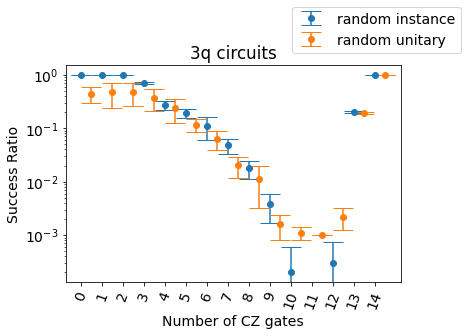

In [6]:
results_self = []
for i in range(10):
    with open(f'results/local_minimums/3q_random_self_rs{i}', 'rb')  as f:
        results_self.append(pickle.load(f))
        
results_unitary = []
for i in range(10):
    with open(f'results/local_minimums/3q_random_unitary_rs{i}', 'rb')  as f:
        results_unitary.append(pickle.load(f))        
        
mean_list_self, std_list_self = mean_and_std(results_self)
mean_list_unitary, std_list_unitary = mean_and_std(results_unitary)

print(f'Mean SR at 6 gates: self {mean_list_self[6]}, unitary {mean_list_unitary[6]}')
print(f'Mean SR at 8 gates: self {mean_list_self[8]}, unitary {mean_list_unitary[8]}')

plt.errorbar(range(len(mean_list_self)), mean_list_self, yerr=std_list_self, fmt='o', capsize=10, label='random instance')
plt.errorbar(jnp.arange(len(mean_list_unitary))+0.5, mean_list_unitary, yerr=std_list_unitary, fmt='o', capsize=10, label='random unitary')

plt.legend(bbox_to_anchor=(1.2, 1.3))

plt.yscale('log')
plt.xticks(range(len(mean_list_self)), rotation=70)
plt.ylabel('Success Ratio')
plt.xlabel('Number of CZ gates')
plt.title('3q circuits')
plt.savefig('figures/3q_success_chart', dpi=1000, bbox_inches='tight')

## 4q chart

Mean SR at 14 gates: self 0.0, unitary 0.0010999999940395355
Mean SR at 18 gates: self 0.0, unitary 0.0021000001579523087


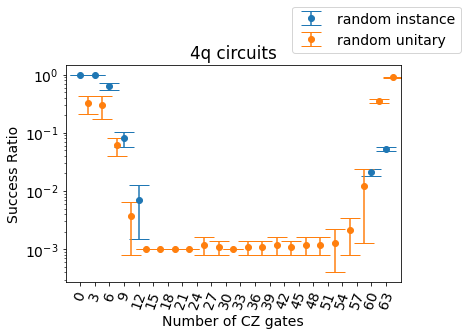

In [7]:
results_self = []
for i in range(10):
    with open(f'results/local_minimums/4q_random_self_rs{i}', 'rb')  as f:
        results_self.append(pickle.load(f))
        
results_unitary = []
for i in range(10):
    with open(f'results/local_minimums/4q_random_unitary_rs{i}', 'rb')  as f:
        results_unitary.append(pickle.load(f))        
        
        
mean_list_self, std_list_self = mean_and_std(results_self)
mean_list_unitary, std_list_unitary = mean_and_std(results_unitary)

print(f'Mean SR at 14 gates: self {mean_list_self[14]}, unitary {mean_list_unitary[14]}')
print(f'Mean SR at 18 gates: self {mean_list_self[18]}, unitary {mean_list_unitary[18]}')

xticks = jnp.arange(theoretical_lower_bound(4)+3)[::3]
plt.errorbar(xticks, mean_list_self, yerr=std_list_self, fmt='o', capsize=10, label='random instance')
plt.errorbar(xticks+1.5, mean_list_unitary, yerr=std_list_unitary, fmt='o', capsize=10, label='random unitary')
plt.legend(bbox_to_anchor=(1.2, 1.3))

plt.xlim([-3, 66])
plt.yscale('log')
plt.xticks(xticks, rotation=70)
plt.ylabel('Success Ratio')
plt.xlabel('Number of CZ gates')
plt.title('4q circuits')
plt.savefig('figures/4q_success_chart', dpi=1000, bbox_inches='tight')        

# CPFlow

## Main ideas

CP templates.

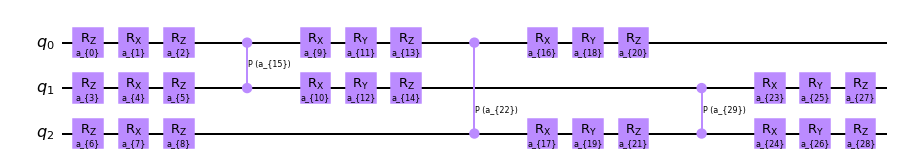

In [8]:
anz = Ansatz(3, 'cp', fill_layers(connected_layer(3),3))
anz.circuit().draw(output='mpl')

Regularization function.

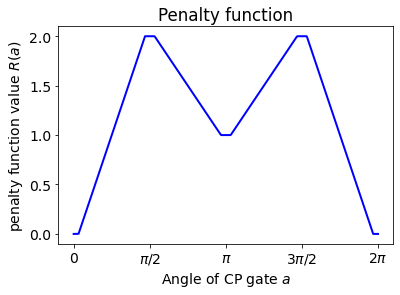

In [9]:
regularization_options = RegularizationOptions(plato_0=0.1, plato_1=0.1, plato_2=0.1)
regularization_func = make_regularization_function(regularization_options)
a_sweep = jnp.linspace(0, 2*jnp.pi, 500)

plt.plot(a_sweep, vmap(regularization_func)(a_sweep), 'blue', linewidth=2)
plt.xticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi], ['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.title('Penalty function')
plt.ylabel('penalty function value $R(a)$')
plt.xlabel('Angle of CP gate $a$')
plt.savefig('figures/penalty', dpi=1000, bbox_inches='tight')        

# Decomposition of the Toffoli gates

## 3q Toffoli

### Connected

Optimal hyperparameters: k=7, r=0.0013153787719205608
Optimal decompositions (out of 100): 28


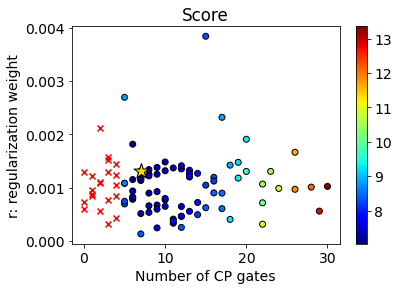

In [17]:
results = Results.load('results/toff3_conn_xyz')
k_best, r_best = results.best_hyperparameters()[0]
optimal_decompositions = [d for d in results.decompositions if d.cz_count==6]
print(f'Optimal hyperparameters: k={k_best}, r={r_best}')
print(f'Optimal decompositions (out of 100): {len(optimal_decompositions)-1}')
results.plot_trials()
plt.savefig('figures/toff3_trials_conn', dpi=1000, bbox_inches='tight')        

Best circuits in each nomination. The circuit with the best $T$-depth is simultaneously the winner in all other nominations.

In [18]:
# for d in tqdm(results.decompositions[1:]):
#     d.refine()
# results.save()

clifford_T_decompositions = [d for d in results.decompositions if d.t_count is not None]

best_cz_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_count)
best_cz_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_depth)
best_t_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_count)
best_t_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_depth)

print(f'Total number of Clifford+T decompositoins (out of 100): {len(clifford_T_decompositions)}')

print(best_cz_count_decomposition)
print(best_cz_depth_decomposition)
print(best_t_count_decomposition)
print(best_t_depth_decomposition)

print('\nBest decomposition:')
best_decomposition = best_t_depth_decomposition
qc = best_decomposition.circuit
qc.draw(output='mpl')

ValueError: min() arg is an empty sequence

This circuit won the appearance in the paper.

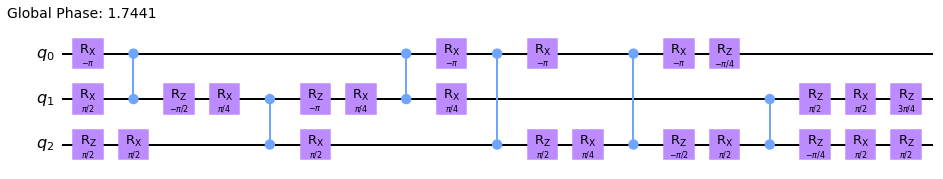

In [20]:
best_decomposition.circuit.draw(output='mpl')

In [23]:
qc = best_decomposition.circuit
target_unitary = Operator(qc.reverse_bits()).data
anz = Ansatz(3, 'cz', placements={'free': get_placements(qc)}, rotation_gates='xyz')

res = anz.learn(
    target_unitary, 
    method='adam',
    learning_rate=0.1,
    num_iterations=5000,
    num_repeats=100)

success_record = [jnp.min(r['loss'])<1e-4 for r in res]
sr = sum(success_record)/len(success_record)
print(f'Success Ratio is {sr}')

Success Ratio is 0.15000000596046448


### Chain

Best hyperparameters: k=14, r=0.000882908121237346
Optimal decompositions (out of 100): 19


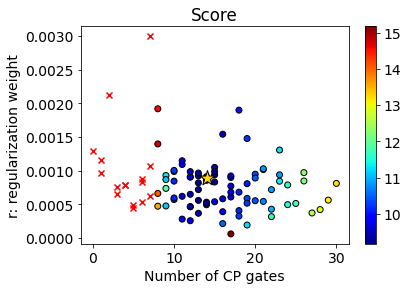

In [21]:
results = Results.load('results/toff3_chain_xyz')
k_best, r_best = results.best_hyperparameters()[0]
optimal_decompositions = [d for d in results.decompositions if d.cz_count==8]
print(f'Best hyperparameters: k={k_best}, r={r_best}')
print(f'Optimal decompositions (out of 100): {len(optimal_decompositions)-1}')
results.plot_trials()
plt.savefig('figures/toff3_trials_chain', dpi=1000, bbox_inches='tight')        

In [22]:
clifford_T_decompositions = [d for d in results.decompositions if d.t_count is not None]

best_cz_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_count)
best_cz_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_depth)
best_t_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_count)
best_t_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_depth)

print(f'Total number of Clifford+T decompositoins (out of 100): {len(clifford_T_decompositions)}')

print(best_cz_count_decomposition)
print(best_cz_depth_decomposition)
print(best_t_count_decomposition)
print(best_t_depth_decomposition)

print('\nBest decomposition:')
best_decomposition = best_t_depth_decomposition
qc = best_decomposition.circuit
qc.draw(output='mpl')

ValueError: min() arg is an empty sequence

## Toffoli 4

### Connected

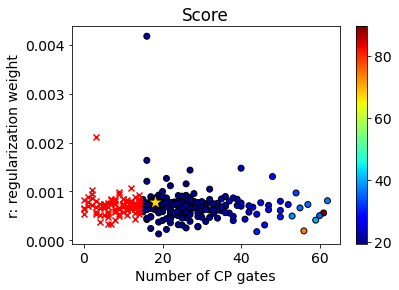

In [38]:
results = Results.load('results/toff4_conn_xyz')
d = results.decompositions[-1]
results.plot_trials()

< toff4_conn_xyz| Rational | loss: 2.384185791015625e-07  | CZ count: 14 | CZ depth: 11  >


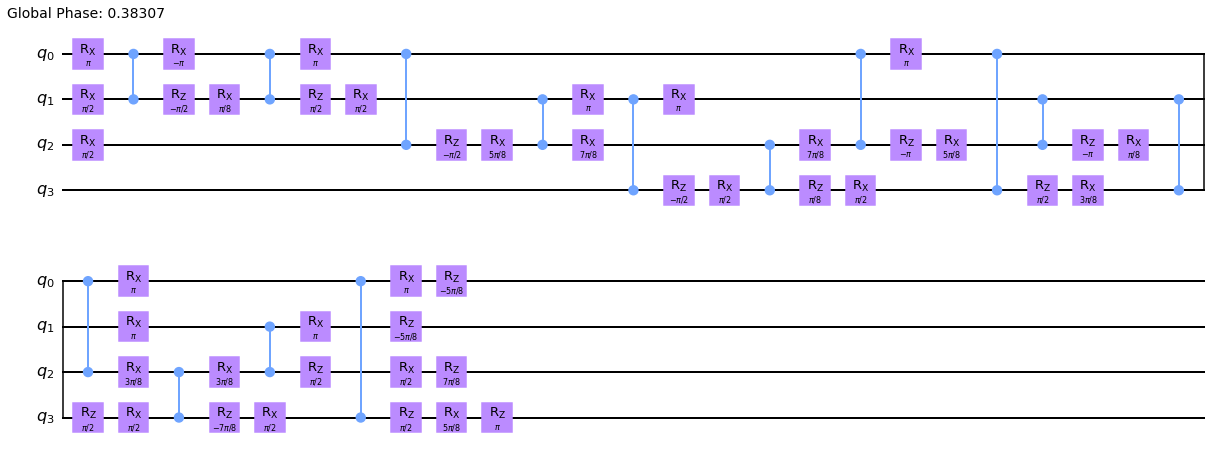

In [39]:
# d.refine()
print(d)
d.circuit.draw(output='mpl')

In [31]:
placements = {'free': get_placements(d.circuit)}
anz = Ansatz(4, 'cz', placements, rotation_gates='xz')

res = anz.learn(
    u_toff4, 
    method='adam',
    learning_rate=0.1,
    num_iterations=5000,
    num_repeats=500)

success_record = [jnp.min(r['loss'])<1e-4 for r in res]
sr = sum(success_record)/len(success_record)
print(f"Success Ratio 'xz' is {sr}")

Success Ratio 'xz' is 0.07800000160932541


In [32]:
placements = {'free': get_placements(d.circuit)}
anz = Ansatz(4, 'cz', placements, rotation_gates='xyz')

res = anz.learn(
    u_toff4, 
    method='adam',
    learning_rate=0.1,
    num_iterations=5000,
    num_repeats=500)

success_record = [jnp.min(r['loss'])<1e-4 for r in res]
sr = sum(success_record)/len(success_record)
print(f"Success Ratio 'xyz' is {sr}")

Success Ratio 'xyz' is 0.006000000052154064


### Kite

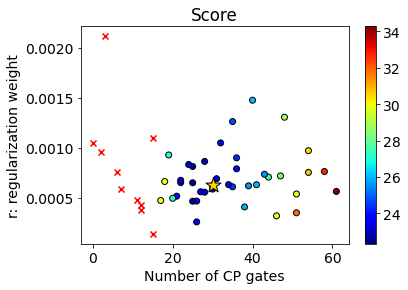

In [40]:
results = Results.load('results/toff4_kite_xyz')
results.plot_trials()

< toff4_kite_xyz| Rational | loss: 1.1920928955078125e-07  | CZ count: 14 | CZ depth: 13  >


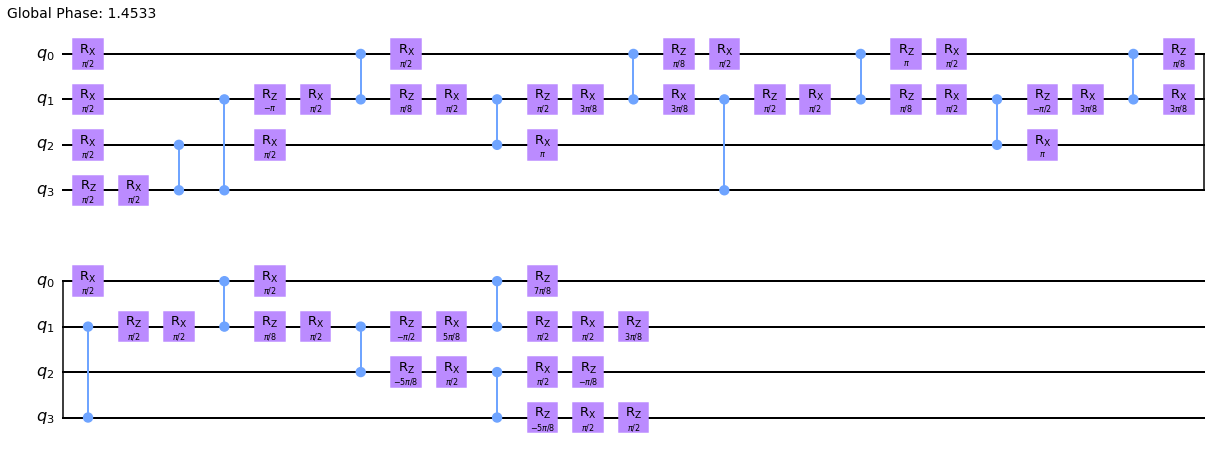

In [42]:
d = results.decompositions[-1]
d.refine()
print(d)
d.circuit.draw(output='mpl')

### Square

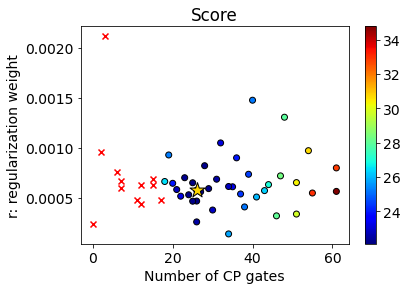

In [17]:
results = Results.load('results/toff4_square_xyz')
results.plot_trials()

< toff4_kite_xyz| Rational | loss: 1.1920928955078125e-07  | CZ count: 14 | CZ depth: 13  >


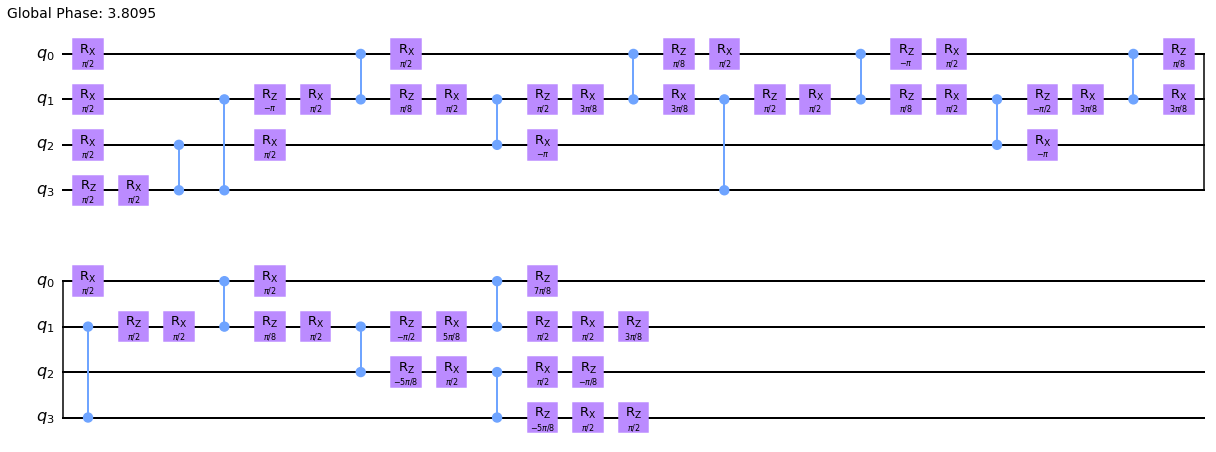

In [47]:
d = results.decompositions[-1]
# d.refine()
print(d)
d.circuit.draw(output='mpl')

### Star

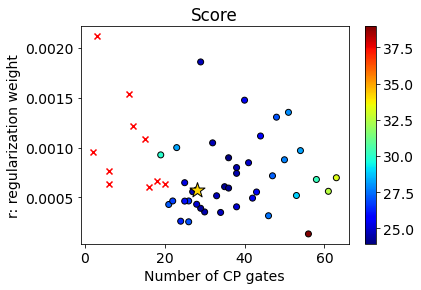

In [51]:
results = Results.load('results/toff4_star_xyz')
results.plot_trials()

In this case our automated procedure failed to make all angles rational.

In [54]:
d = results.decompositions[-1]
# d.refine()
print(d)

< toff4_star_xyz| Approximate | loss: 0.0  | CZ count: 16 | CZ depth: 16  >


Here is a quick and dirty workaround manually rounding off gate angles.

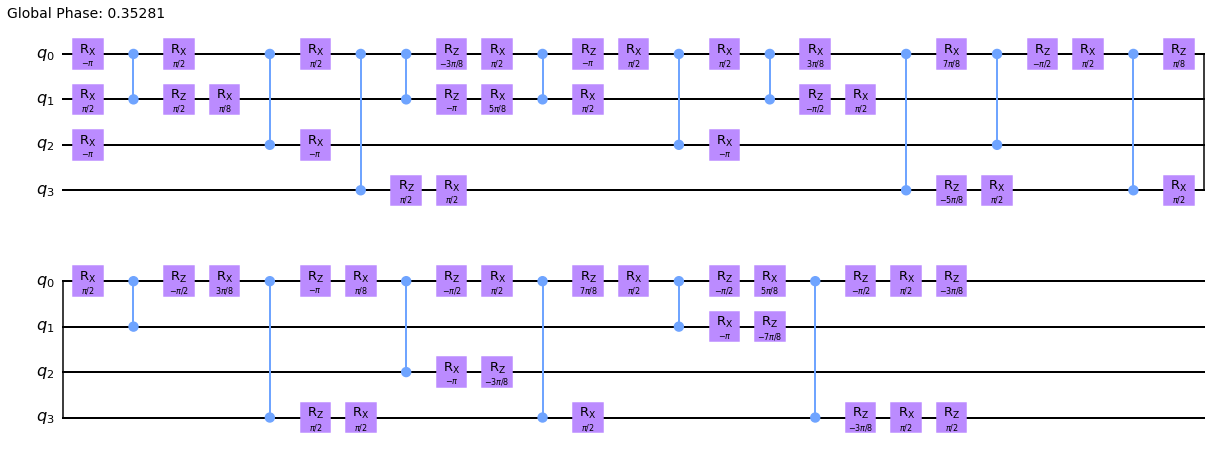

In [59]:
qx = d.circuit.copy()

new_data = []
for gate, qargs, cargs in qx.data:
    if gate.name in ['rx', 'ry', 'rz']:
        new_gate = gate
        angle = bracket_angle(gate.params[0])
        new_gate.params = [jnp.pi * Fraction.from_float(angle/jnp.pi).limit_denominator(8)]
    else:
        new_gate = gate
    new_data.append((gate, qargs, cargs))

qx.data = new_data
qx = remove_zero_rgates(qx)
qx.draw(output='mpl')

Let's check that the resulting circuit indeed compiles the 4q Toffoli within machine precision.

In [60]:
cost_HST(Operator(qx.reverse_bits()).data, u_toff4)

DeviceArray(0., dtype=float32)

Here is the split that was used to fit the circuit into the paper width.

In [63]:
qx_0 = qx.copy()
qx_1 = qx.copy()

split = 36

qx_0.data = qx.data[:split]
qx_1.data = qx.data[split:]

print(cost_HST(Operator(qx).data, Operator(qx_0.compose(qx_1)).data))

1.1920929e-07


"Upper" circuit at fig.11 

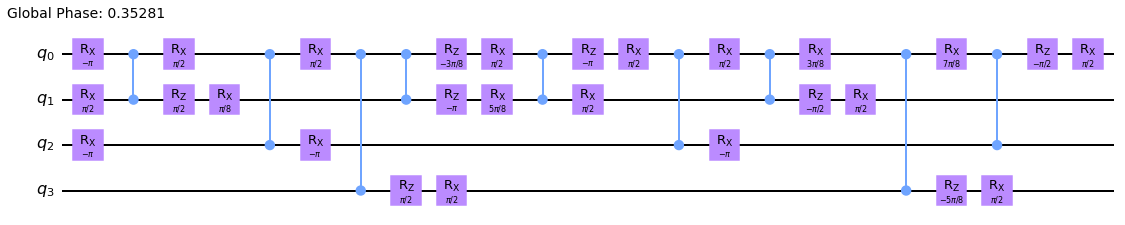

In [64]:
qx_0.draw(output='mpl')

"Lower" circuit at fig.11

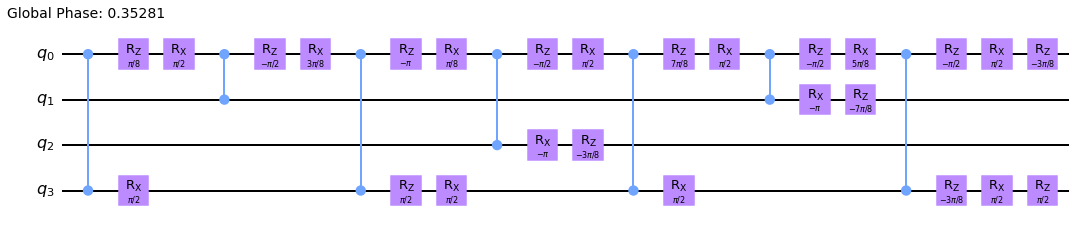

In [65]:
qx_1.draw(output='mpl')

In [84]:
placements = {'free': get_placements(qx)}

anz = Ansatz(4, 'cz', placements, rotation_gates='xyz')

res = anz.learn(
    u_toff4, 
    method='adam',
    learning_rate=0.1,
    num_iterations=5000,
    num_repeats=500)

success_record = [jnp.min(r['loss'])<1e-4 for r in res]
sr = sum(success_record)/len(success_record)
print(f"Success Ratio 'xyz' is {sr}")

Success Ratio 'xyz' is 0.004000000189989805


In [89]:
placements = {'free': get_placements(qx)}

anz = Ansatz(4, 'cz', placements, rotation_gates='xz')

res = anz.learn(
    u_toff4, 
    method='adam',
    learning_rate=0.1,
    num_iterations=5000,
    num_repeats=500)

success_record = [jnp.min(r['loss'])<1e-4 for r in res]
sr = sum(success_record)/len(success_record)
print(f"Success Ratio 'xz' is {sr}")

Success Ratio 'xyz' is 0.0020000000949949026


### Chain

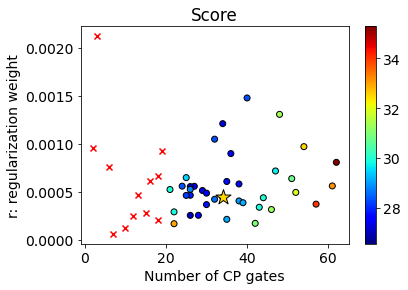

In [66]:
results = Results.load('results/toff4_chain_xyz')
results.plot_trials()

< toff4_chain_xyz| Rational | loss: 0.0  | CZ count: 18 | CZ depth: 14  >


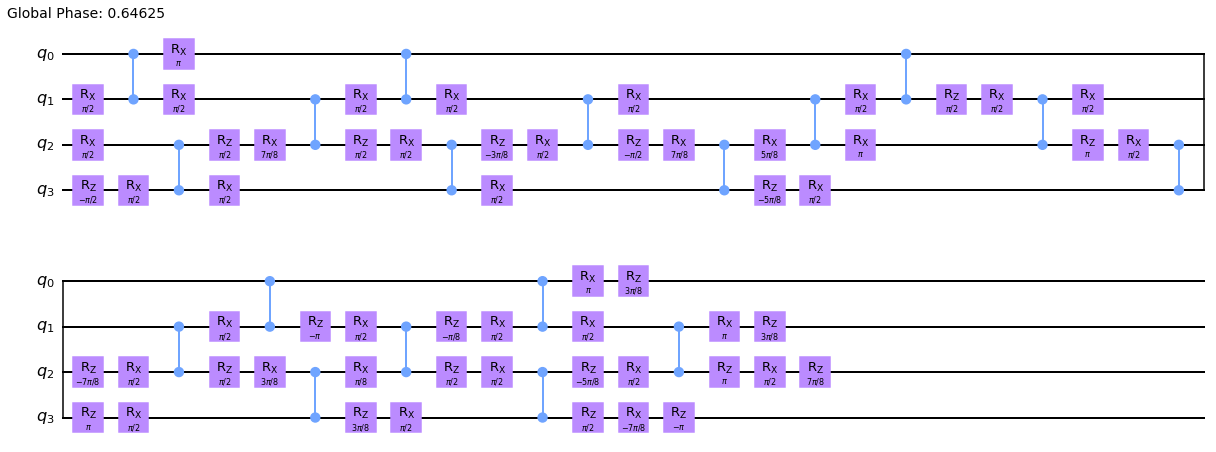

In [67]:
d = results.decompositions[-1]
d.refine()
print(d)
d.circuit.draw(output='mpl')

## Toffoli 5

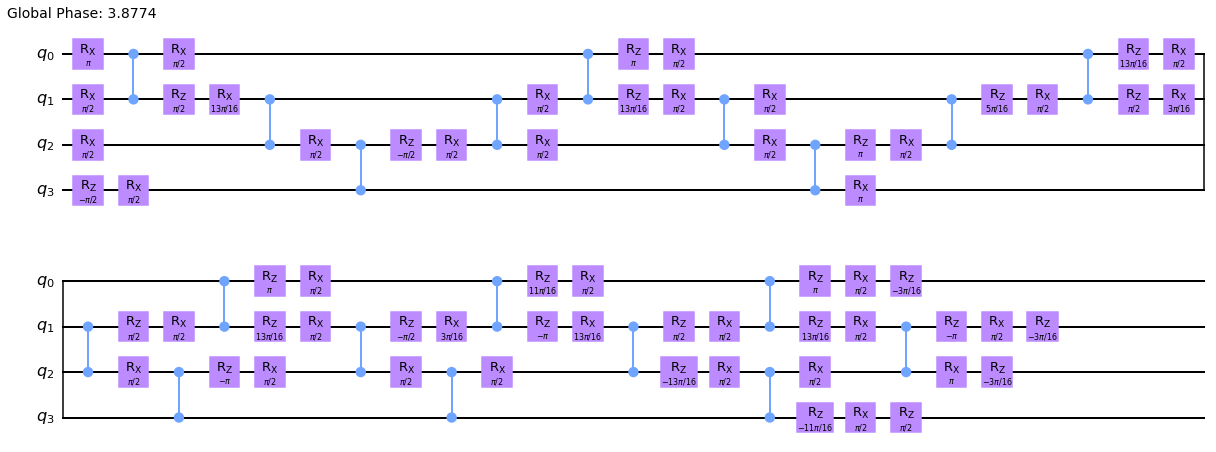

In [114]:
results = Results.load('results/toff4_sqrt_chain')
d = results.decompositions[-1]
# d.refine()
print(d)

qc_toff4_sqrt = d.circuit

g_toff4_sqrt = qc_toff4_sqrt.reverse_bits().to_instruction(label='T4_sqrt')
g_toff4_sqrt.name = 'T4_sqrt'

qc_toff4_sqrt.draw(output='mpl')

< toff4_relative_chain| Approximate | loss: 3.3868501336797863e-09  | CZ count: 11 | CZ depth: 9  >


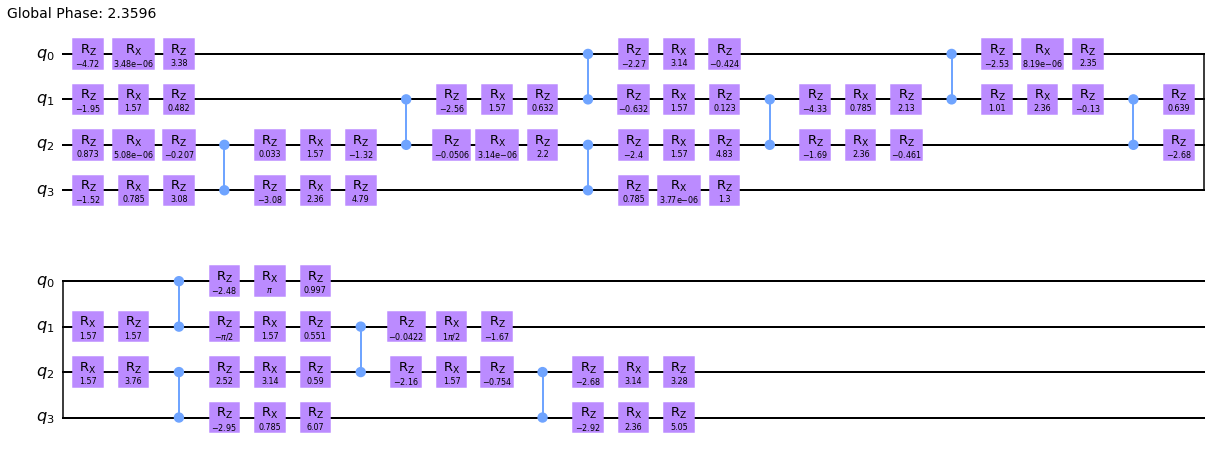

In [115]:
results = Results.load('results/toff4_relative_chain')
d = results.decompositions[2]
# d.refine()
print(d)

qc_toff4_relative = d.circuit
g_toff4_relative = qc_toff4_relative.reverse_bits().to_instruction(label='RT4')
g_toff4_relative.name = 'RT4'

qc_toff4_relative.draw(output='mpl')

Partially analytic decompositions that gives the optimal CZ count on the fully connected topology.

0.0
True


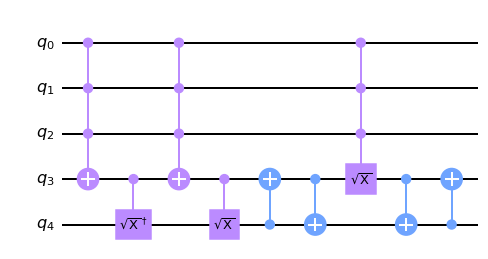

In [132]:
qc = QuantumCircuit(5)

# qc.append(g_toff4_relative, [0, 1, 2, 3])
qc.mct([0, 1, 2], 3)
qc.append(SXGate().control(1).inverse(), [3, 4])
# qc.append(g_toff4_relative.inverse(), [0, 1, 2, 3])

qc.mct([0, 1, 2], 3)

qc.append(SXGate().control(1), [3, 4])

qc.cx(4,3)
qc.cx(3,4)
# qc.append(g_toff4_sqrt, [0, 1, 2, 3])
qc.append(SXGate().control(3), [0, 1, 2, 3])
qc.cx(3,4)
qc.cx(4,3)

print(cost_HST(Operator(qc.reverse_bits()).data, u_toff5))
print(jnp.allclose(Operator(qc.reverse_bits()).data, u_toff5))
qc.draw(output='mpl')

Adaptation of the above decomposition to the chain topology with synthesized relative Toffoli 4 gate.

0.20458978
False


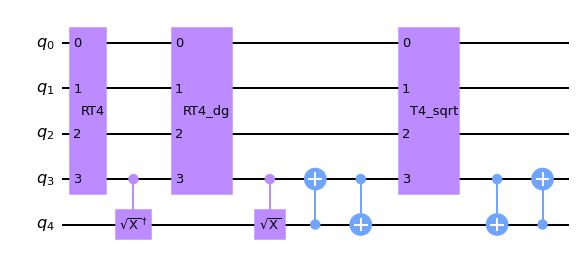

In [116]:
qc = QuantumCircuit(5)

qc.append(g_toff4_relative, [0, 1, 2, 3])
qc.append(SXGate().inverse().control(1), [3, 4])
qc.append(g_toff4_relative.inverse(), [0, 1, 2, 3])

qc.append(SXGate().control(1), [3, 4])

qc.cx(4,3)
qc.cx(3,4)
qc.append(g_toff4_sqrt, [0, 1, 2, 3])
qc.cx(3,4)
qc.cx(4,3)

print(cost_HST(Operator(qc.reverse_bits()).data, u_toff5))
print(jnp.allclose(Operator(qc.reverse_bits()).data, u_toff5, rtol=1e-7, atol=1e-5))
qc.draw(output='mpl')

# Benchmark circuits

In [27]:
@dataclass
class benchmark_circuit:
    name: str
    cpflow: int    
    squander: int
    qfast: int
    qsearch: int
    
    num_trials: int = -1
    label: str = ''
        
    def original_circuit(self):
        return QuantumCircuit.from_qasm_file(f'benchmark_circuits/Table {self.label[-1]}/{self.name}.qasm')
    
    def check_cpflow(self):
        results = Results.load(f'results/benchmarks/res_{self.name}')
        decompositions = results.decompositions
        best_decomposition = min(decompositions, key = lambda d: d.cz_count)
        
        qc = best_decomposition.circuit
        assert cost_HST(Operator(qc).data, Operator(self.original_circuit()).data) < 1e-6
        if self.label=='t3':  # Third table contains circuits that are compiled onto the chain topology.
            placements = get_placements(qc)
            breaks_topology = False in [p in chain_layer(5) for p in placements]
            assert not breaks_topology, 'Breaks topology'
        self.cpflow = best_decomposition.cz_count
        self.num_trials = len(results.trials.results)

benchmark_circuits = [
    benchmark_circuit('4gt5_76', -1, 24, 29, -1, label='t1'),
    benchmark_circuit('one-two-three-v2_100', -1, 37, 52, 43, label='t1'),
    benchmark_circuit('alu-v3_34', -1, 25, 37, 27, label='t1'),
    benchmark_circuit('alu-v4_36', -1, 40, 49, -1, label='t1'),
    benchmark_circuit('4gt13_92', -1, 24, 46, -1, label='t1'),

    benchmark_circuit('4gt13_91', -1, 26, 55, 35, label='t3'),
    benchmark_circuit('4gt5_76', -1, 26, 51, 27, label='t3'),
    benchmark_circuit('alu-v0_26', -1, 32, 56, -1, label='t3'),
    benchmark_circuit('alu-v3_35', -1, 26, 62, 34, label='t3'),
    benchmark_circuit('4mod5-v1_24', -1, 31, 81, 44, label='t3'),

    benchmark_circuit('4gt10-v1_81', -1, 39, -1, -1, label='t4'),
    benchmark_circuit('one-two-three-v1_99', -1, 45, -1, -1, label='t4'),
    benchmark_circuit('one-two-three-v0_98', -1, 61, -1, -1, label='t4'),
    benchmark_circuit('aj-e11_165', -1, 36, -1, -1, label='t4'),
    benchmark_circuit('alu-v2_32', -1, 41, -1, -1, label='t4')]

Currently `benchmark_circuits` are initialized without decompositions found by cpflow. We now fill in those, verify against the original circuits (and connectivity) and report results in a table.

In [29]:
for bc in benchmark_circuits:
    try:
        bc.check_cpflow()
    except (AssertionError, ValueError) as e:
        print(bc.name)
        print(e)

table_data = []
for bc in benchmark_circuits:
    table_data.append(vars(bc))
    
DataFrame(table_data, range(len(table_data)))

4gt5_76
Breaks topology


,name,cpflow,squander,qfast,qsearch,num_trials,label
0,4gt5_76,21,24,29,-1,100,t1
1,one-two-three-v2_100,28,37,52,43,100,t1
2,alu-v3_34,14,25,37,27,100,t1
3,alu-v4_36,30,40,49,-1,100,t1
4,4gt13_92,17,24,46,-1,100,t1
5,4gt13_91,25,26,55,35,100,t3
6,4gt5_76,-1,26,51,27,-1,t3
7,alu-v0_26,28,32,56,-1,100,t3
8,alu-v3_35,24,26,62,34,100,t3
9,4mod5-v1_24,29,31,81,44,100,t3


In [28]:
def encoding(a, b):
    qc = QuantumCircuit(5)
    qc.initialize([a, b], 0)
    
    qc.s(0)
    qc.h(2)
    qc.h(3)
    qc.cx(2, 4)
    qc.cx(3, 1)
    qc.h(1)
    qc.cx(3,4)
    qc.cx(1,0)
    qc.s(0)
    qc.s(1)
    qc.s(2)
    qc.s(3)
    qc.sdg(4)
    qc.cx(4, 0)
    qc.h(4)
    qc.cx(4, 1)
    
    return Statevector.from_instruction(qc)

In [3]:
def cost_overlap(s1, s2):
    return 1-jnp.abs((s1.conj()*s2).sum())**2

def cost_state(u, state):
    null_state = jnp.zeros(u.shape[0], dtype=jnp.float32)
    null_state = null_state.at[0].set(1)
    
    prepared_state = u@null_state
    
    return cost_overlap(prepared_state, state)

In [55]:
qc = QuantumCircuit(3)
Statevector.from_instruction(qc).data

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [45]:
from qiskit.quantum_info import Statevector

qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.cz(0,1)
qc.x(0)
qc.cx(0,1)
qc.y(1)

test_state = Statevector.from_instruction(qc).data

decomposer = Synthesize(connected_layer(2), unitary_loss_func=lambda u: cost_state(u, test_state), label='state test')
options = StaticOptions(num_cp_gates=4, num_samples=5, accepted_num_cz_gates=2)
results = decomposer.static(options)


Starting decomposition routine with the following options:

 StaticOptions(num_samples=5, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, num_cp_gates=4, r=0.00055, accepted_num_cz_gates=2)

Computing raw results...

Selecting prospective results...

Found 2. Verifying...


  0%|          | 0/2 [00:00<?, ?it/s]


2 successful. cz counts are:
[2, 2]


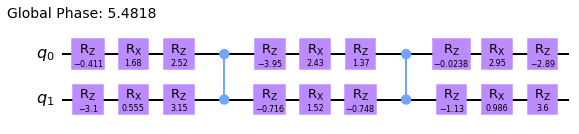

In [46]:
results = Results.load('results/state test')
d = results.decompositions[-1]
# d.refine()
d.circuit.draw(output='mpl')

In [47]:
d.refine()

'Refined to Approximate'

In [48]:
d.circuit.draw()

global phase: 0.3601
     ┌───────┐ ┌────────────┐┌───────┐   ┌─────────────┐┌────────────┐┌───────┐»
q_0: ┤ Rz(0) ├─┤ Rx(1.6752) ├┤ Rz(0) ├─■─┤ Rz(-1.4275) ├┤ Rx(2.4295) ├┤ Rz(0) ├»
     ├───────┤┌┴────────────┤├───────┤ │ └┬────────────┤├────────────┤├───────┤»
q_1: ┤ Rz(0) ├┤ Rx(0.55466) ├┤ Rz(0) ├─■──┤ Rz(2.4373) ├┤ Rx(1.5216) ├┤ Rz(0) ├»
     └───────┘└─────────────┘└───────┘    └────────────┘└────────────┘└───────┘»
«         ┌────────────┐ ┌────────────┐┌─────────────┐
«q_0: ─■──┤ Rz(1.3419) ├─┤ Rx(2.9531) ├┤ Rz(-2.8861) ├
«      │ ┌┴────────────┤┌┴────────────┤├─────────────┤
«q_1: ─■─┤ Rz(-1.8765) ├┤ Rx(0.98584) ├┤ Rz(-2.6837) ├
«        └─────────────┘└─────────────┘└─────────────┘

In [49]:
from exact_decompositions import *

In [50]:
u, angs, wires = qiskit_circ_to_jax_unitary(d.circuit)
lf = lambda a: d.unitary_loss_func(u(a))

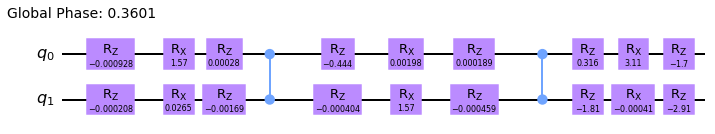

In [51]:
l_angles = lasso_angles(lf, jnp.array(angs), eps=1e-5)
replace_angles_in_circuit(d.circuit, l_angles).draw(output='mpl')

In [17]:
1.03/jnp.pi

0.3278591827693044

## 

In [91]:
test_state

array([0.+0.j        , 0.-0.70710678j, 0.+0.70710678j, 0.+0.j        ])

In [95]:
norm = -4.80349160e-01-5.18907168e-01j
comp_state = Statevector.from_instruction(d.circuit.reverse_bits()).data
comp_state

array([ 1.24426258e-05+1.04062112e-05j,  3.91323475e-01+5.88953332e-01j,
       -3.91325301e-01-5.88951966e-01j,  4.63484417e-06+1.51558266e-05j])

In [97]:
cost_overlap(comp_state, test_state)

DeviceArray(1.1920929e-07, dtype=float32)

In [39]:
cost_overlap(jnp.array([1/jnp.sqrt(2),-1/jnp.sqrt(2)]), jnp.array([1/jnp.sqrt(2),1/jnp.sqrt(2)]))

DeviceArray(1., dtype=float32)

In [29]:
qc = QuantumCircuit(3)
print(Statevector.from_instruction(qc))
print(Statevector.from_instruction(qc.reverse_bits()))

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


# Circuit refinement

In [52]:
decomposer = Synthesize(connected_layer(3), target_unitary=u_toff3, label='refine_test')
options = StaticOptions(num_cp_gates=7, num_samples=1, accepted_num_cz_gates=6, random_seed=1, rotation_gates='xz')
results = decomposer.static(options)


Starting decomposition routine with the following options:

 StaticOptions(num_samples=1, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=1, rotation_gates='xz', num_cp_gates=7, r=0.00055, accepted_num_cz_gates=6)

Computing raw results...

Selecting prospective results...

Found 1. Verifying...


  0%|          | 0/1 [00:00<?, ?it/s]


1 successful. cz counts are:
[6]


\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{{$\mathrm{global\,phase:\,} \mathrm{2.7482}$}
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{R_Z}\,(\mathrm{\frac{\pi}{2}})} & \gate{\mathrm{R_X}\,(\mathrm{\pi})} & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \ctrl{1} & \gate{\mathrm{R_Z}\,(\mathrm{-2.356})} & \gate{\mathrm{R_X}\,(\mathrm{1.257e-05})} & \gate{\mathrm{R_Z}\,(\mathrm{4.511})} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \gate{\mathrm{R_X}\,(\mathrm{0.7854})} & \gate{\mathrm{R_Z}\,(\mathrm{\frac{\pi}{2}})} & \control\qw & \gate{\mathrm{R_Z}\,(\mathrm{-3.142})} & \gate{\mathrm{R_X}\,(\mathrm{1.571})} & \gate{\mathrm{R_Z}\,(\mathrm{3.685})} & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \gate{\mathrm{R_X}\,(\mathrm{1.489})} & \gate{\mathrm{R_Z}\,(\m

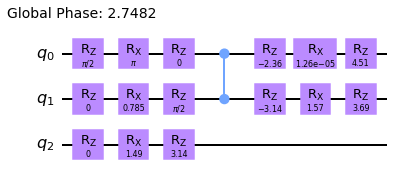

In [73]:
d = results.decompositions[-1]
qc= d.circuit

qc0 = qc.copy()
qc1 = qc.copy()

split = 35

qc0.data = qc.data[:split]
qc1.data = qc.data[split:]

print(qc1.draw(output='latex_source'))

qc1.draw(output='mpl')

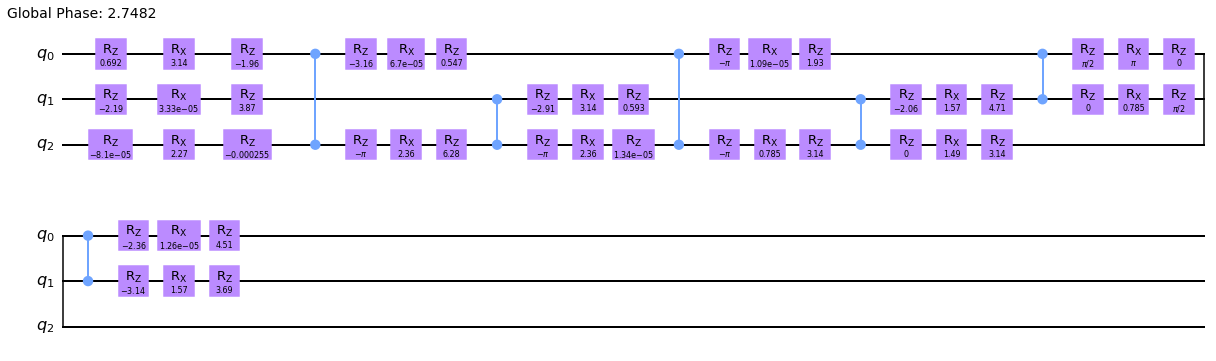

In [64]:
qc.draw(output='mpl')

In [74]:
qc_reduced = reduce_angles(qc, d.unitary_loss_func)
qc_reduced = remove_zero_rgates(qc_reduced)

qc_reduced.draw(output='mpl')
print(qc_reduced.draw(output='latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{{$\mathrm{global\,phase:\,} \mathrm{6.084}$}
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{R_X}\,(\mathrm{3.142})} & \ctrl{2} & \qw & \qw & \qw & \qw & \qw & \ctrl{2} & \qw & \qw & \qw & \qw & \ctrl{1} & \gate{\mathrm{R_X}\,(\mathrm{-\pi})} & \qw & \ctrl{1} & \gate{\mathrm{R_Z}\,(\mathrm{0.7852})} & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \qw & \qw & \qw & \qw & \ctrl{1} & \gate{\mathrm{R_X}\,(\mathrm{3.141})} & \qw & \qw & \qw & \qw & \ctrl{1} & \gate{\mathrm{R_X}\,(\mathrm{1.571})} & \control\qw & \gate{\mathrm{R_Z}\,(\mathrm{-1.571})} & \gate{\mathrm{R_X}\,(\mathrm{0.7854})} & \control\qw & \gate{\mathrm{R_Z}\,(\mathrm{-1.571})} & \gate{\mathrm{R_X}\,(\mathrm{1.571})} & \gate{\mathrm{R_Z}\,(\mathrm{-2.357})} & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & 

In [76]:
qc_rationalized = rationalize_all_rgates(qc_reduced)

qc_rationalized.draw(output='mpl')
print(qc_rationalized.draw(output='latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{{$\mathrm{global\,phase:\,} \mathrm{6.084}$}
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{R_X}\,(\mathrm{\pi})} & \ctrl{2} & \qw & \qw & \qw & \qw & \qw & \ctrl{2} & \qw & \qw & \qw & \qw & \ctrl{1} & \gate{\mathrm{R_X}\,(\mathrm{-\pi})} & \qw & \ctrl{1} & \gate{\mathrm{R_Z}\,(\mathrm{\frac{\pi}{4}})} & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \qw & \qw & \qw & \qw & \ctrl{1} & \gate{\mathrm{R_X}\,(\mathrm{\pi})} & \qw & \qw & \qw & \qw & \ctrl{1} & \gate{\mathrm{R_X}\,(\mathrm{\frac{\pi}{2}})} & \control\qw & \gate{\mathrm{R_Z}\,(\mathrm{\frac{-\pi}{2}})} & \gate{\mathrm{R_X}\,(\mathrm{\frac{\pi}{4}})} & \control\qw & \gate{\mathrm{R_Z}\,(\mathrm{\frac{-\pi}{2}})} & \gate{\mathrm{R_X}\,(\mathrm{\frac{\pi}{2}})} & \gate{\mathrm{R_Z}\,(\mathrm{\frac{-3\pi}{4}})} & \qw & \qw\